# Descrição do Projeto

A empresa Sweet Lift Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de **táxi para a próxima hora.** 	
Construa um modelo para tal predição.

A métrica REQM no conjunto de teste não deve ser superior a 48.

### Importando as bibliotecas

In [65]:
%pip install statsmodels -q

Note: you may need to restart the kernel to use updated packages.


In [66]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import warnings


### Verificando o dataset

In [67]:
df = pd.read_csv('taxi.csv', parse_dates=[0],index_col = [0])
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### informação dos dados

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Estatistica dos dados

In [69]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


In [70]:
df.isna().sum()

num_orders    0
dtype: int64

### Amostragem para uma hora de diferença


In [71]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


In [72]:
print(df.columns)


Index(['num_orders'], dtype='object')


### Amostragem para uma hora de diferença

In [73]:
df_1h = df.resample('1H').sum()
df_1h

C:\Users\prasd\AppData\Local\Temp\ipykernel_27412\170689485.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_1h = df.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Verificação do grafico

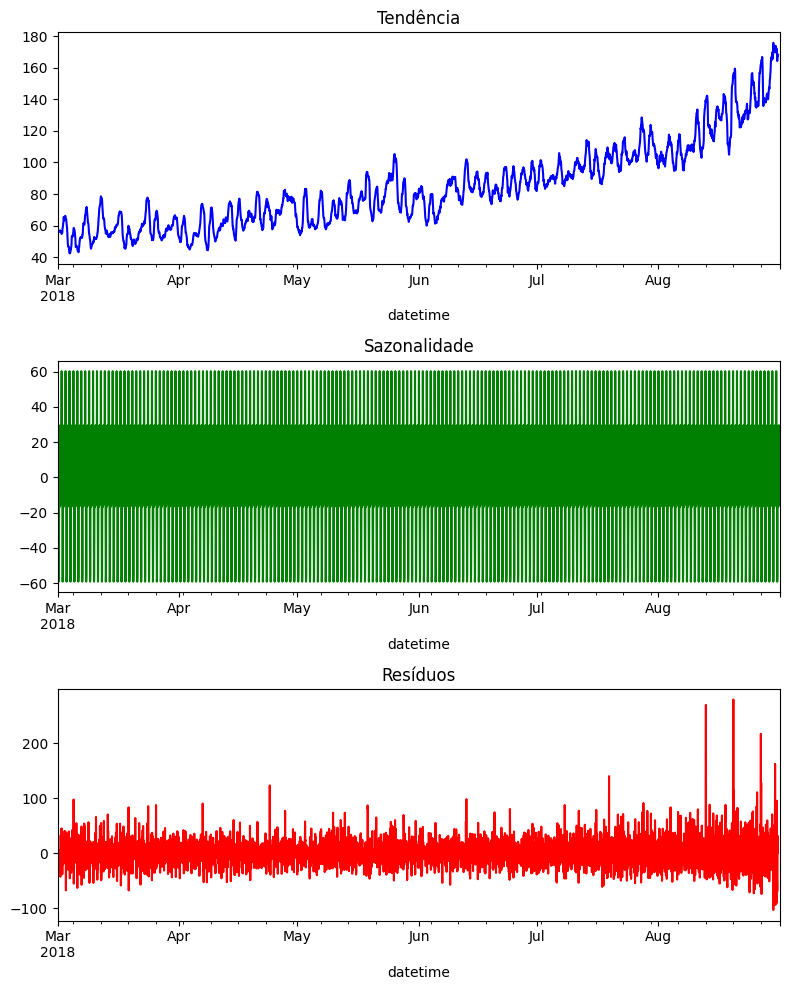

In [74]:
result = seasonal_decompose(df_1h['num_orders'], model='additive', period=24) 


plt.figure(figsize=(8, 10))

plt.subplot(311)
result.trend.plot(ax=plt.gca(), color='blue')
plt.title('Tendência')


plt.subplot(312)
result.seasonal.plot(ax=plt.gca(), color='green')
plt.title('Sazonalidade')


plt.subplot(313)
result.resid.plot(ax=plt.gca(), color='red')
plt.title('Resíduos')

plt.tight_layout()
plt.show()


### Teste adfuller

In [75]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_1h.num_orders.values)
print(f'saida do teste:\n{result[4]}\n')

saida do teste:
{'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}



In [76]:
print(f"Estatística do teste: %f" % result[0])
print(f"p-value: %f" % result[1])
print(f"Número de lags utilizados no teste: %f" % result[2])
print(f"Quantidade de observações utilizadas no teste: %i" % result[3])
print(f"Valores Críticos: {result[4]}")

print("\nValores Críticos:")
critical_values = result[4]
for key, value in critical_values.items():
    print('\t{}:{:.3f} - A Série e {} Estacionaria com {}% de confiança'.format(
    key, value, 'não' if value<result[0] else '', 100-float(key[:-1])))
    

Estatística do teste: -3.068924
p-value: 0.028940
Número de lags utilizados no teste: 30.000000
Quantidade de observações utilizadas no teste: 4385
Valores Críticos: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}

Valores Críticos:
	1%:-3.432 - A Série e não Estacionaria com 99.0% de confiança
	5%:-2.862 - A Série e  Estacionaria com 95.0% de confiança
	10%:-2.567 - A Série e  Estacionaria com 90.0% de confiança


### TesteKPSS

In [77]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings('ignore', category=InterpolationWarning)


result = kpss(df_1h.num_orders.values)
print(f'saida do teste:\n{result}\n')

saida do teste:
(10.913353384602186, 0.01, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})



In [78]:
print(f"Estatística do teste: %f" % result[0])
print(f"p-value: %f" % result[1])
print(f"Número de lags utilizados no teste: %f" % result[2])
print(f"Valores Críticos: {result[3]}")

print("\nValores Críticos:")
critical_values = result[3]
for key, value in critical_values.items():
    print(f'\t{key}: {value:.3f} - A Série  {"não" if value< result[0] else "é"} Estacionaria com {100-float(key[:-1])}%  de confiança')

Estatística do teste: 10.913353
p-value: 0.010000
Número de lags utilizados no teste: 32.000000
Valores Críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

Valores Críticos:
	10%: 0.347 - A Série  não Estacionaria com 90.0%  de confiança
	5%: 0.463 - A Série  não Estacionaria com 95.0%  de confiança
	2.5%: 0.574 - A Série  não Estacionaria com 97.5%  de confiança
	1%: 0.739 - A Série  não Estacionaria com 99.0%  de confiança


### Juntando os dois testes

In [79]:
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series):
    for test_name, test in {'Adfuller': adfuller, 'KPSS': kpss}.items():
        result = test(series.values)
        print(f"\033[34m{test_name}\033[0m")
        print(f'p-value: %.3f' % result[1])

      
        critical_values = result[4] if test_name == "Adfuller" else result[3]
        critical_values = critical_values["5%"] 

        check_adfuller = (test_name == "Adfuller") & (result[1] <= 0.05) & (critical_values > result[0])
        check_kpss = (test_name == "KPSS") & (result[1] > 0.05) & (critical_values > result[0])


        if check_adfuller | check_kpss:
            print("\033[32mEstacionária com nível de confiança de 95%\033[0m") 
        else:
            print("\033[31mNão estacionária com nível de confiança de 95%\033[0m") 
        print("\n")


check_stationarity(df_1h.num_orders.dropna())



Adfuller
p-value: 0.029
Estacionária com nível de confiança de 95%


KPSS
p-value: 0.010
Não estacionária com nível de confiança de 95%




### Dados de uma Hora

<Axes: xlabel='datetime'>

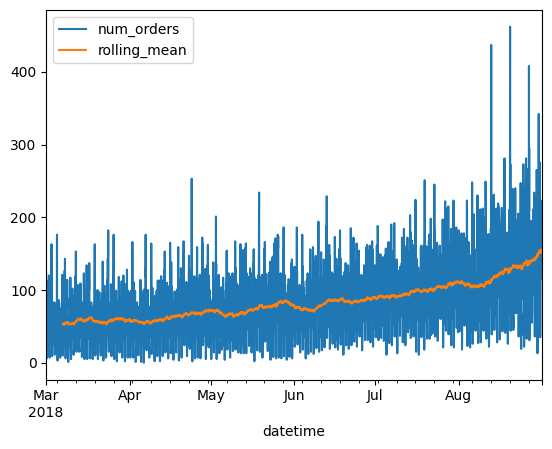

In [80]:
df_1h_mean = df_1h
df_1h_mean['rolling_mean'] = df_1h.rolling(150).mean()
df_1h_mean.plot()

### Analisando periodo menor de 24 horas

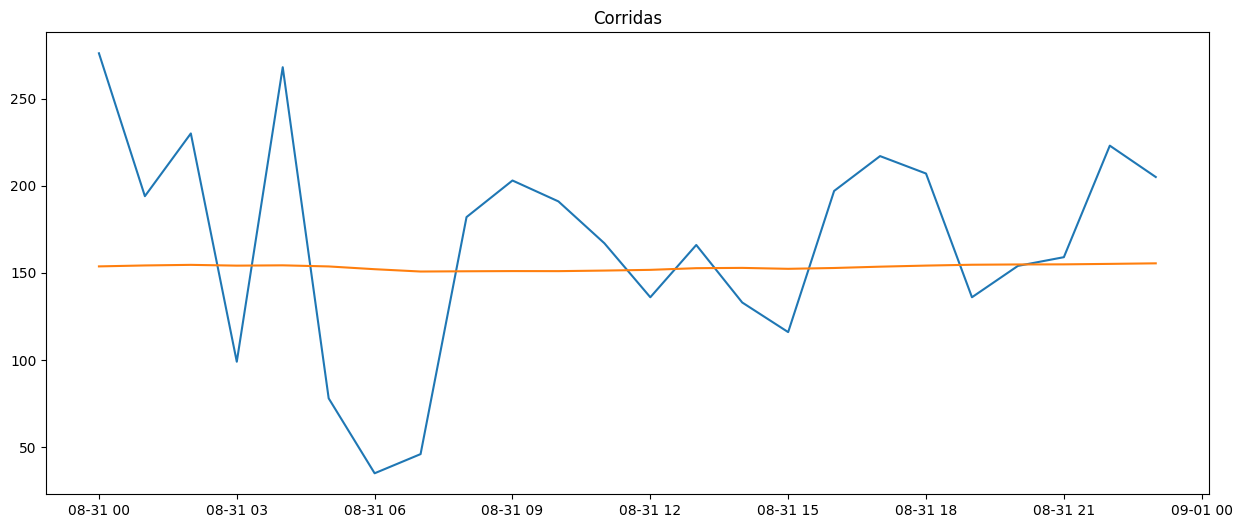

In [81]:
plt.figure(figsize=(15,6))
plt.plot(df_1h.iloc[-24:])
plt.title('Corridas')
plt.show();


### Treinamento


#### Criando as características

In [82]:
def make_features(df_1h, max_lag, rolling_mean_size):
    df_1h['year'] = df_1h.index.year
    df_1h['month'] = df_1h.index.month
    df_1h['day'] = df_1h.index.day
    df_1h['dayofweek'] = df_1h.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_1h['lag_{}'.format(lag)] = df_1h['num_orders'].shift(lag)

    df_1h['rolling_mean'] = df_1h['num_orders'].shift().rolling(rolling_mean_size).mean()

#### Aplicando a funçõa

In [83]:
make_features(df_1h, 4, 4)



Nesses dois últimos comandos, criei novas características para o modelo que vão ajudar na previsão. São elas:

-  ano
-  mês
-  dia
-  dia da semana

Fiz isso para podermos ter um detalhamento maior de todos os fatores que podem afetar nosso modelo.


### Separando o conjunto de teste e treino

In [84]:
train, test = train_test_split(df_1h, shuffle=False, test_size=0.1)

#### Separando as características e objetivos do modelo

In [85]:
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Treinando o modelo de regressão linear

In [86]:
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression()

### Floresta Aleatória


#### Calibrando os hiperparâmetros

In [87]:
rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [5, 10, 15,20], 
    'max_depth': [1, 5, 10]
}

In [88]:
from sklearn.model_selection import GridSearchCV

df_1h = df_1h.dropna()
df_1h.drop(['rolling_mean'], axis=1)
X = df_1h.drop(['num_orders'], axis=1)
y = df_1h['num_orders']

rf_grid2 = GridSearchCV(rf_model, param_grid, cv=10, scoring='neg_mean_squared_error')
rf_grid2.fit(X, y)

print('Melhores hiperparâmetros: ', rf_grid2.best_params_)
print('Melhor pontuação REQM : ', np.sqrt((-1)*rf_grid2.best_score_))

Melhores hiperparâmetros:  {'max_depth': 10, 'n_estimators': 15}
Melhor pontuação REQM :  34.11038067603553


#### Treinando o modelo 

In [89]:
rf_model = RandomForestRegressor(max_depth= 5, n_estimators= 15)

rf_model.fit(X, y)

RandomForestRegressor(max_depth=5, n_estimators=15)

## Testando

###  Modelo de regressão linear


In [90]:
import numpy as np
from sklearn.metrics import mean_squared_error
pred_rl = model.predict(features_test)


rla = np.sqrt(mean_squared_error(target_test, pred_rl))


print('REQM para o conjunto de teste:', rla)

REQM para o conjunto de teste: 52.60663237167778


### Modelo de Floresta Aleatória

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf3 = RandomForestRegressor(random_state=42)
rf3.fit(X_train, y_train)
pred_rf3 = rf3.predict(X_test)
mfa = np.sqrt(mean_squared_error(y_test, pred_rf3))
print('REQM para o conjunto de teste:', mfa)

REQM para o conjunto de teste: 31.735421875020094


### Modelo Arima

In [92]:
import statsmodels.api as sm
order_result = sm.tsa.arma_order_select_ic(
    df_1h.num_orders.diff().dropna(),  # série temporal estacionária
    max_ar=10,  # qual o valor máximo de p que ele irá buscar
    max_ma=10,  # qual o valor máximo de q que ele irá buscar
    ic=['aic', 'bic'],  # critérios a serem calculados durante a busca
    trend='c'
)
print('ARMA(p,q) =', order_result['aic_min_order'], 'is the best.')

print("Order that minimizes AIC:", order_result.aic_min_order)
print("Order that minimizes BIC:", order_result.bic_min_order)


c:\Users\prasd\webScraping\webScraping-1\.conda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\prasd\webScraping\webScraping-1\.conda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\prasd\webScraping\webScraping-1\.conda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\prasd\webScraping\webScraping-1\.conda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

ARMA(p,q) = (10, 6) is the best.
Order that minimizes AIC: (10, 6)
Order that minimizes BIC: (10, 6)


c:\Users\prasd\webScraping\webScraping-1\.conda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\prasd\webScraping\webScraping-1\.conda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\prasd\webScraping\webScraping-1\.conda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                 4412
Model:                ARIMA(10, 1, 6)   Log Likelihood              -21509.538
Date:                Mon, 18 Nov 2024   AIC                          43053.076
Time:                        23:31:11   BIC                          43161.738
Sample:                    03-01-2018   HQIC                         43091.403
                         - 08-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7444      0.092     -8.050      0.000      -0.926      -0.563
ar.L2         -0.2125      0.041     -5.169      0.000      -0.293      -0.132
ar.L3         -0.4813      0.036    -13.501      0.0

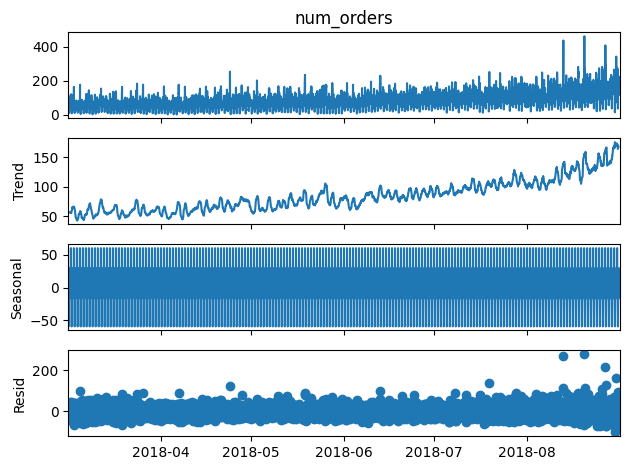

In [93]:
from statsmodels.tsa.arima.model import ARIMA
decomposition = seasonal_decompose(df_1h.num_orders, model='additive')
decomposition.plot()  
model = ARIMA(df_1h.num_orders, order=(10, 1, 6))
ar_model = model.fit()
print(ar_model.summary())  


In [94]:
predictions = ar_model.predict(start=0, end=len(df_1h.num_orders)-1)
rmse = np.sqrt(np.mean((df_1h.num_orders - predictions) ** 2))
print(f'RMSE: {rmse}')

RMSE: 31.678053915075242


In [95]:
print('Arima RMSE',rmse)
print('Floresta aleatoria REQM', mfa)
print('Regressão linear', rla)


Arima RMSE 31.678053915075242
Floresta aleatoria REQM 31.735421875020094
Regressão linear 52.60663237167778


## Conclusão

Realizamos uma análise detalhada dos dados, identificando uma clara tendência de crescimento no número de pedidos de táxi no aeroporto ao longo do tempo. Em seguida, desenvolvemos dois modelos preditivos: Regressão Linear e Regressão com Floresta Aleatória. Ambos os modelos apresentaram um REQM inferior ao limite estipulado no exercício, que era 48. No entanto, como o modelo de Floresta Aleatória demonstrou melhor desempenho nessa tarefa, recomendo que adotemos este modelo para previsões futuras